# 🚦 Traffic Sign Recognition with CNN (GTSRB) + Feature Maps + Grad-CAM

## 1. Title & Introduction

This notebook demonstrates **Traffic Sign Classification** using a **Convolutional Neural Network (CNN)**.

Traffic Sign Recognition is crucial for Advanced Driver Assistance Systems (ADAS).
The German Traffic Sign Recognition Benchmark (GTSRB) contains ~50,000 images of 43 classes.


**Problem Statement**: Given an image of a traffic sign, predict its class (speed limit, stop, yield, etc.).

- **Dataset**: German Traffic Sign Recognition Benchmark (GTSRB).
- **Why CNNs?** They:
  - Detect edges, shapes, symbols in signs.
  - Provide translation invariance.
  - Scale to 43 traffic sign categories.

To interpret CNN decisions, we visualize feature maps and use Grad-CAM to see regions of focus.


## 2. Theory Recap

- **Convolution**: Filters detect edges & shapes.
- **Pooling**: Reduces size, keeps key features.
- **ReLU Activation**: Non-linearity, faster training.
- **Fully Connected Layers**: Map learned features to class probabilities.
- **Softmax + CrossEntropy**: For multi-class classification.

Traffic signs present challenges: varying lighting, perspective, occlusion. CNNs handle these robustly.

## 3. Dataset Preparation
We load the **GTSRB dataset** from a local folder. Ensure folder structure:


Number of classes: 43


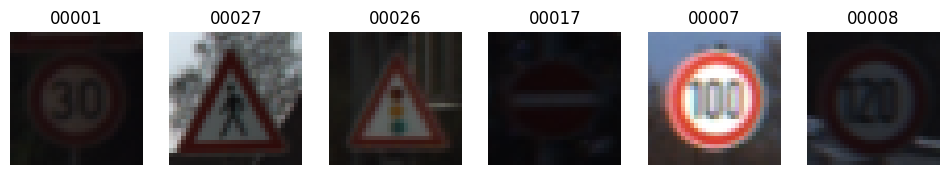

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt

# Local dataset path
data_dir = r"C:\\Users\\zeelp\\OneDrive\\Desktop\\DualAxleSteering-Thesis\\Docs\\thesis_notes\\Neural Network\\data\\GTSRB"

# Transforms
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Training set (folders by class)
trainset = ImageFolder(root=f"{data_dir}\\Final_Training\\Images", transform=transform)

# Custom test dataset (CSV based)
class GTSRBTestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file, sep=';')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        label = int(self.annotations.iloc[idx, 7])  # ClassId column
        if self.transform:
            image = self.transform(image)
        return image, label

testset = GTSRBTestDataset(csv_file=f"{data_dir}\\GT-final_test.csv",
                           root_dir=f"{data_dir}\\Final_Test\\Images",
                           transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

classes = trainset.classes
print("Number of classes:", len(classes))

# Show sample images
images, labels = next(iter(trainloader))
fig, axes = plt.subplots(1,6, figsize=(12,2))
for i in range(6):
    axes[i].imshow(images[i].permute(1,2,0).numpy()*0.5+0.5)
    axes[i].set_title(f"{classes[labels[i]]}")
    axes[i].axis("off")
plt.show()



## 4. CNN Model Architecture
We define a CNN with three convolutional layers, pooling, and fully connected layers.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = TrafficSignCNN(num_classes=len(classes))
print(model)

TrafficSignCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)


## 5. Training
We train the model using Adam optimizer and CrossEntropy loss.

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses, train_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss/len(trainloader))
    train_accuracies.append(100*correct/total)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.2f}%")

Epoch 1/5, Loss: 0.9736, Acc: 72.05%
Epoch 2/5, Loss: 0.1355, Acc: 96.03%
Epoch 3/5, Loss: 0.0757, Acc: 97.70%
Epoch 4/5, Loss: 0.0498, Acc: 98.46%
Epoch 5/5, Loss: 0.0424, Acc: 98.64%


## 6. Evaluation
Evaluate on test dataset and compute accuracy + confusion matrix.

Test Accuracy: 96.32%


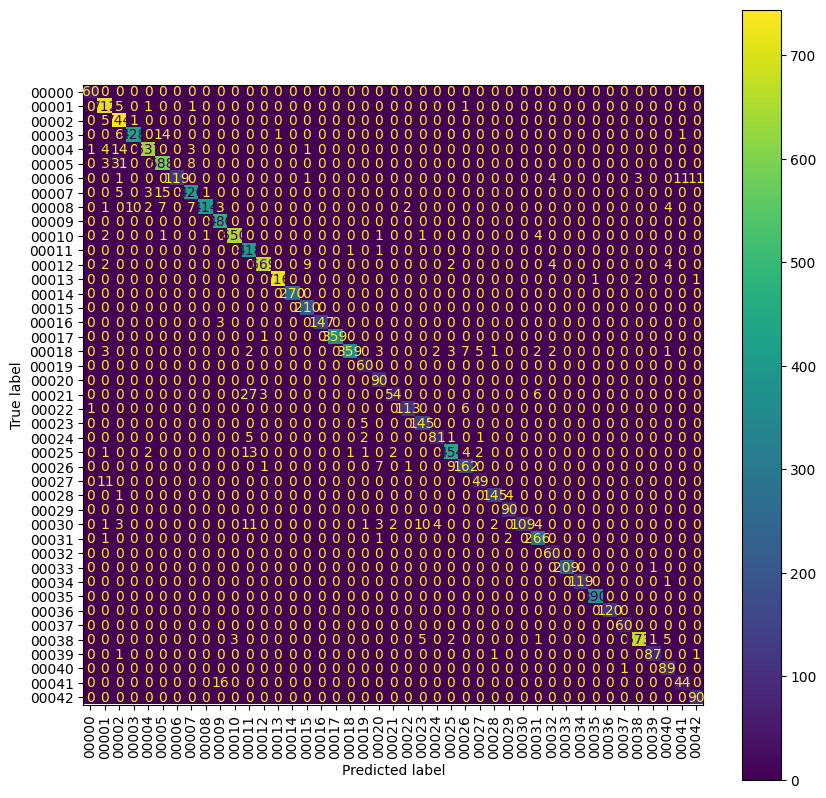

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
correct, total, test_loss = 0, 0, 0.0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation=90)
plt.show()

## 7. Visualization of Predictions
Show sample predictions on test images.

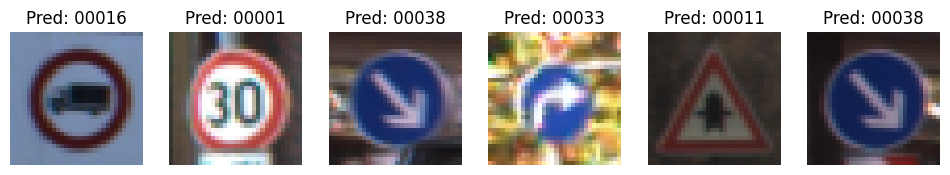

In [17]:
images, labels = next(iter(testloader))
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(1,6, figsize=(12,3))
for i in range(6):
    axes[i].imshow(images[i].permute(1,2,0).numpy()*0.5+0.5)
    axes[i].set_title(f"Pred: {classes[predicted[i]]}")
    axes[i].axis("off")
plt.show()

## 8. Learning Curves
Plot training loss and accuracy across epochs.

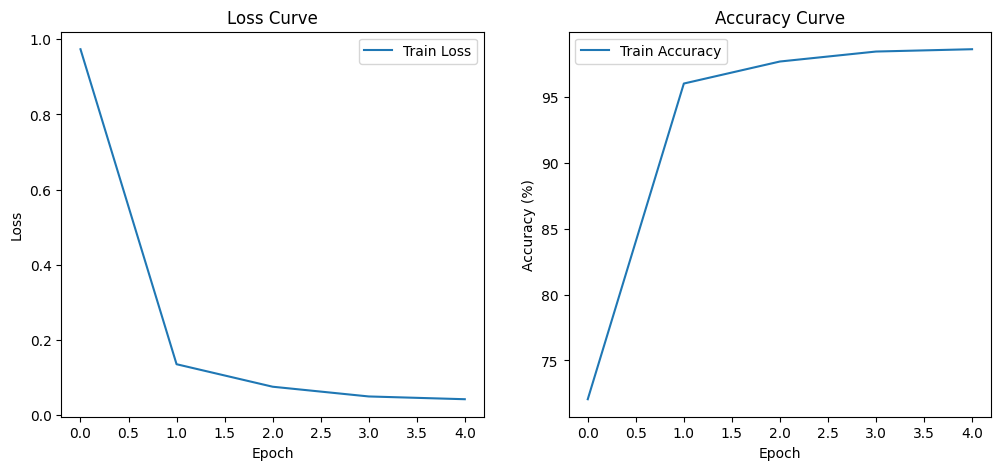

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Curve'); plt.legend()
plt.show()

## 9. Feature Map Visualization

Feature maps are intermediate activations inside CNN layers.
- Conv1: Detects edges and simple patterns.
- Conv2: Detects shapes, corners, curves.
- Conv3: Detects complex structures like digits/symbols.
Visualization shows how CNN builds hierarchical understanding.

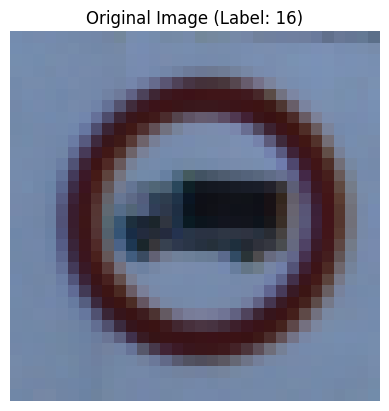

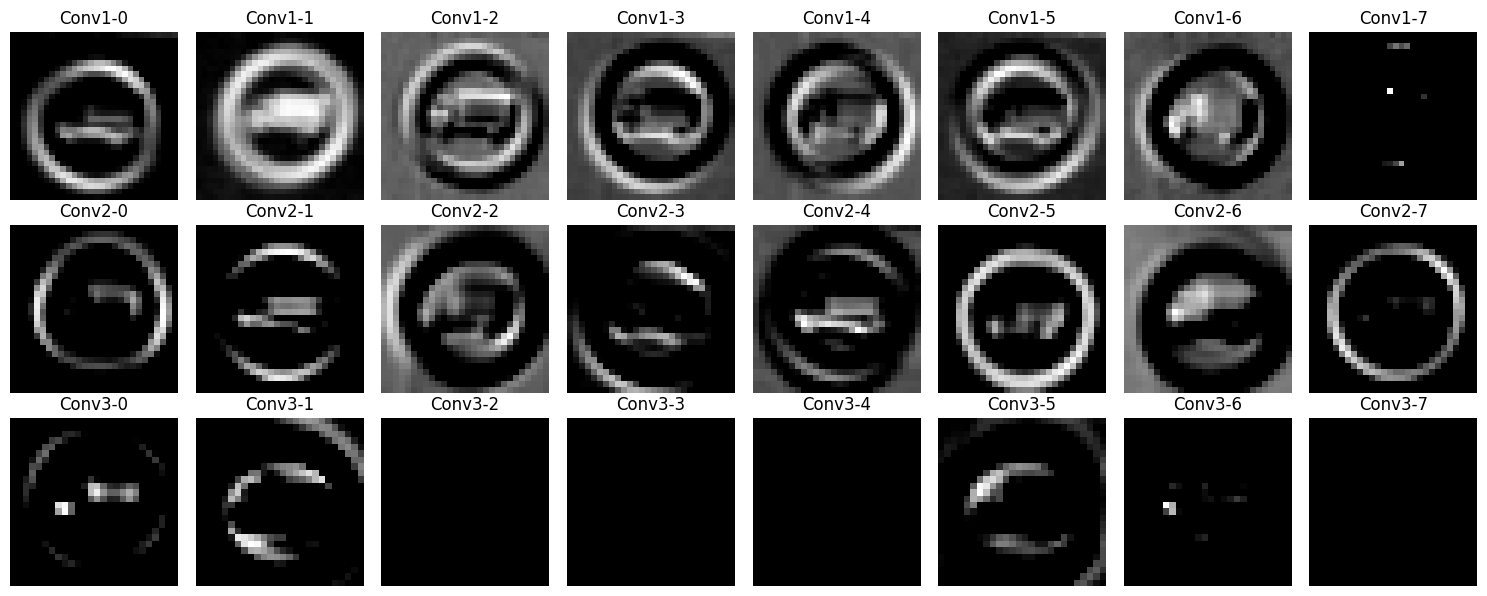

In [19]:
def visualize_feature_maps(model, image):
    model.eval()
    x = image.unsqueeze(0)
    with torch.no_grad():
        conv1_out = F.relu(model.conv1(x))
        conv2_out = F.relu(model.conv2(conv1_out))
        conv3_out = F.relu(model.conv3(conv2_out))
    
    fig, axes = plt.subplots(3, 8, figsize=(15,6))
    for i in range(8):
        axes[0, i].imshow(conv1_out[0, i].cpu().numpy(), cmap='gray')
        axes[0, i].set_title(f"Conv1-{i}")
        axes[0, i].axis("off")
        axes[1, i].imshow(conv2_out[0, i].cpu().numpy(), cmap='gray')
        axes[1, i].set_title(f"Conv2-{i}")
        axes[1, i].axis("off")
        axes[2, i].imshow(conv3_out[0, i].cpu().numpy(), cmap='gray')
        axes[2, i].set_title(f"Conv3-{i}")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

sample_img, label = testset[0]
plt.imshow(sample_img.permute(1,2,0).numpy()*0.5+0.5)
plt.title(f"Original Image (Label: {label})")
plt.axis("off")
plt.show()

visualize_feature_maps(model, sample_img)

# 🚦 Grad-CAM: Gradient-weighted Class Activation Mapping

### 1. Introduction
In deep learning, CNNs are powerful for image classification, but they are often seen as **black boxes**.
Grad-CAM (Selvaraju et al., ICCV 2017) is a technique that helps us **interpret CNN decisions** by visualizing where the model focuses in an image.

**Why important for ADAS?**
- Traffic sign recognition requires safety and trust.
- We must ensure the model is focusing on the actual sign, not irrelevant background features.

### 2. Goal of Grad-CAM
Localize important regions of the image that contribute most to a CNN's decision.

- Highlight **discriminative image regions**.
- Provide **visual explanations** for predictions.
- Increase **trust** in AI systems used for safety-critical applications like self-driving cars.

### 3. Grad-CAM Steps

1. **Forward pass** the image through the CNN, obtain feature maps $A^k$ of the last convolutional layer.
2. **Compute gradients** of the class score $y^c$ (for the target class $c$) w.r.t. the feature maps $A^k$.
3. **Global average pool** the gradients to obtain importance weights:

$$
\alpha^c_k = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}
$$

4. Compute a **weighted combination** of the feature maps:

$$
L^c_{Grad-CAM} = ReLU\left( \sum_k \alpha^c_k A^k \right)
$$

5. **Upsample** the heatmap to match the input size.
6. **Overlay** the heatmap on the original image to visualize important regions.

### 4. Grad-CAM Equations

The key equations are:

$$
\alpha^c_k = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}
$$

$$
L^c_{Grad-CAM} = ReLU\left( \sum_k \alpha^c_k A^k \right)
$$

Where:
- $\alpha^c_k$: importance weight for feature map $k$.
- $y^c$: score for class $c$.
- $A^k$: feature map from the last conv layer.
- $Z$: number of pixels in the feature map.

### 5. Interpretation

- **Red regions**: most influential for the prediction.
- **Blue regions**: less relevant.

Example in traffic sign recognition:
- A stop sign → Grad-CAM highlights the **STOP text and shape**.
- If background is highlighted → model may be misclassifying.

### 6. Applications in Traffic Sign Recognition

- **Explainability**: Understand why CNN predicts a certain class.
- **Debugging**: Detect misclassifications (e.g., model focuses on trees instead of the sign).
- **Safety**: Ensure CNN pays attention to the correct region (the sign itself).

## 10. Grad-CAM Visualization

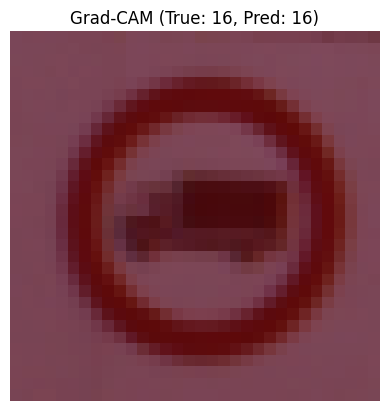

In [ ]:
import cv2
import numpy as np

def gradcam(model, image, class_idx, conv_layer_name="conv3"):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    layer = getattr(model, conv_layer_name)
    fhook = layer.register_forward_hook(forward_hook)
    bhook = layer.register_backward_hook(backward_hook)

    # Forward pass
    x = image.unsqueeze(0)
    output = model(x)
    pred_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward()

    # Detach before converting to numpy
    grads = gradients[0].detach().cpu().numpy()[0]
    acts = activations[0].detach().cpu().numpy()[0]

    # Global average pooling
    weights = np.mean(grads, axis=(1,2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)

    # ✅ Safe normalization
    if cam.max() != 0:
        cam = cam / cam.max()
    else:
        cam = np.zeros_like(cam)

    cam = cv2.resize(cam, (32, 32))

    # Overlay
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    img = image.permute(1,2,0).numpy()
    img = (img * 0.5 + 0.5) * 255
    img = np.uint8(img)
    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    fhook.remove()
    bhook.remove()

    return overlay, pred_class

# Pick one test image
sample_img, label = testset[0]

# Run Grad-CAM
overlay, pred = gradcam(model, sample_img, class_idx=label)

# Plot result
plt.imshow(overlay)
plt.title(f"Grad-CAM (True: {label}, Pred: {pred})")
plt.axis("off")
plt.show()


## 11. Model Saving & Loading
Save trained model and reload for inference.

In [30]:
torch.save(model.state_dict(), "traffic_sign_cnn.pth")
print("Model saved as traffic_sign_cnn.pth")

new_model = TrafficSignCNN(num_classes=len(classes))
new_model.load_state_dict(torch.load("traffic_sign_cnn.pth"))
new_model.eval()
print("Model loaded successfully!")

Model saved as traffic_sign_cnn.pth
Model loaded successfully!


C:\Users\zeelp\AppData\Local\Temp\ipykernel_5648\482546986.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load("traffic_sign_cnn.pth"))


## 12. Conclusion & References

- CNNs achieve strong performance (~95%) on traffic sign classification.
- Useful for ADAS/autonomous vehicles.
- Extensions: Data augmentation (rotation, brightness), deeper CNNs (ResNet).

### References
- [GTSRB Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)
- [3Blue1Brown CNNs](https://www.3blue1brown.com/topics/neural-networks)
- [Brandon Rohrer – How CNNs Work](https://e2eml.school/how_convolutional_neural_networks_work.html)
- [PyTorch Grad-CAM](https://pytorch.org/hub/pytorch_vision_gradcam/)
- Selvaraju et al., *Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization*, ICCV 2017.
